# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import train_test_split
import pickle
import pdb
import numpy as np
# pickle file locations
training_file = 'train.p'
testing_file = 'test.p'

# load pickle data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = len(y_train) # Before spliting training data into train and validation data. See cell below for post splitting lengths


# Number of testing examples.
n_test = len(y_test) 

# Shape of traffic sign image
image_shape = np.array(X_train.shape[1:4])#[32, 32, 3]

# Number of unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size #43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32 32  3]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

6
(39209, 32, 32, 3)


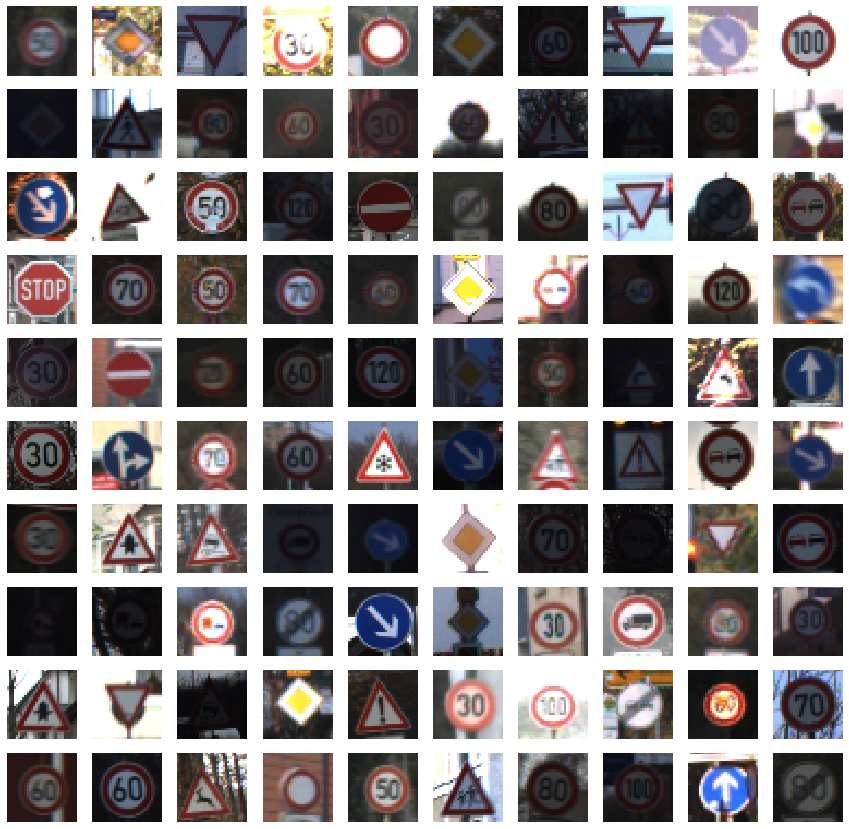

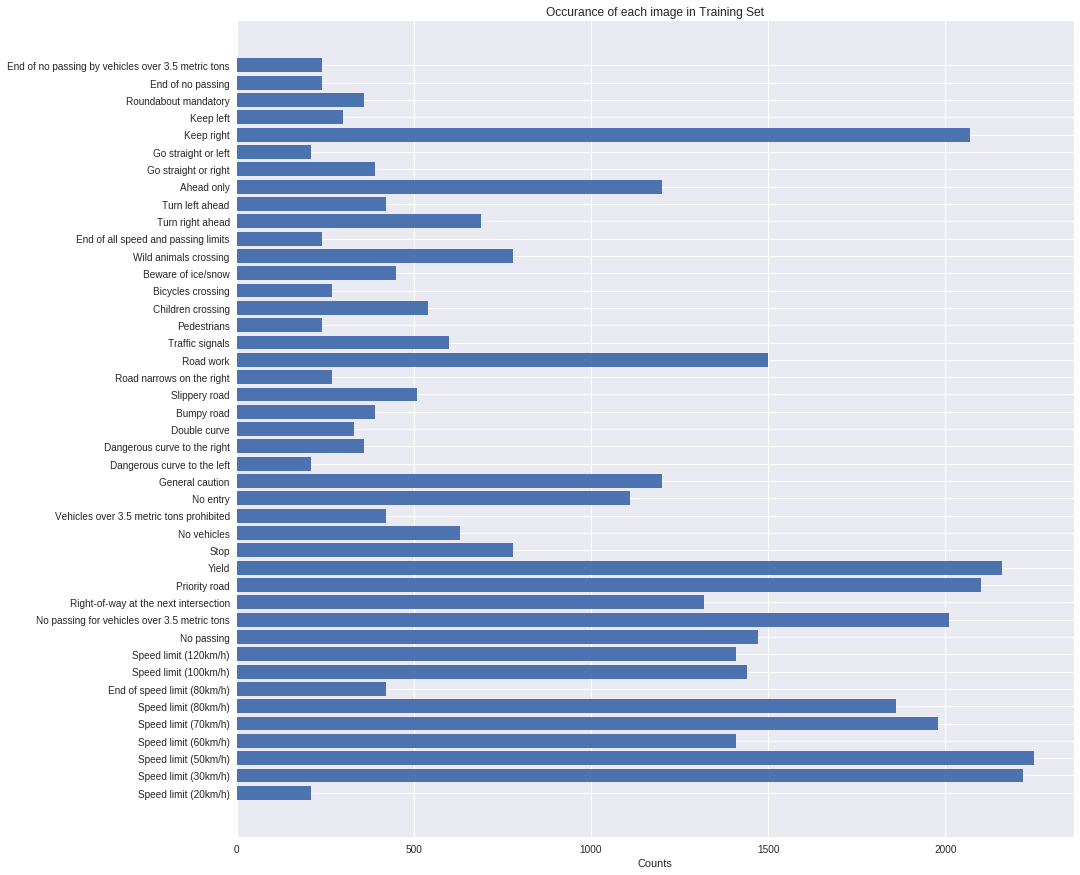

In [22]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

#plot a bunch of random examples
subplot_width = 10
plt.figure(figsize=(15,15))
for index in range(subplot_width**2):
    plt.subplot(subplot_width,subplot_width,index+1)
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

# plot occurances
unique, counts = np.unique(y_train, return_counts=True)
df=pd.read_csv('/home/myles-iribarne/Documents/Self-Driving-Car-Nanodegree-Term1/CarND-Traffic-Sign-Classifier-Project/signnames.csv')
df_names = df['SignName']
df_name_array = df_names.values
# import pdb; pdb.set_trace()
# df_names = df('ID')
# y_pos = np.arange(len(objects))
# performance = [10,8,6,4,2,1]
plt.figure(figsize=(15,15))
plt.barh(unique,counts)
plt.yticks(unique, df_name_array)
plt.xlabel('Counts')
plt.title('Occurance of each image in Training Set')
 


# plt.figure(figsize=(1,1))
# plt.imshow(edges)
print(y_train[index])
print(X_train.shape)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

## My implementation

### Preprocess Data
- Convert to Grayscale using: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
- Equalize the histogram using: cv2.equalizeHist(img)
- Normalized the image using: cv2.normalize(image, image, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [30]:
import cv2
from sklearn.utils import shuffle
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
def norml(image):
    #normalize to between -0.5 and 0.5 and output in float
    cv2.normalize(image, image, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) 
    return image

def preprocess(images):
    images = np.array([norml(cv2.equalizeHist(grayscale(image))) for image in images])
    images = images[..., np.newaxis]
    return images
    

X_train = preprocess(X_train)
X_test = preprocess(X_test)
# Covert to grayscale and normalize histogram and scale to 0.5 to 0.5
# X_train = np.array([preprocess(image) for image in X_train])
# X_train = X_train[..., np.newaxis]
# X_test = np.array([preprocess(image) for image in X_test])
# X_test = X_test[..., np.newaxis]


# shuffle input data
X_train, y_train = shuffle(X_train, y_train)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
To preprocess the data, I used the following pipeline:
- Convert to Grayscale using: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
- Equalize the histogram using: cv2.equalizeHist(img)
- Normalized the image using: cv2.normalize(image, image, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

I chose to use grayscale because the published result "Traffic Sign Recognition with Multi-Scale Convolutional Networks" showed that it performed better than color. I also tested this myself and did not notice a significant difference in performance, so I chose the simpler of the two options

Equalizing the histogram and normalizing the data both serve the purpose of standardizing the images somewhat to make them more comparable to each other.


In [4]:
### and split the data into training/validation/testing sets here.
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)


assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))



# Number of training examples
n_train = len(y_train) 
n_validation = len(y_validation)

# Number of testing examples.
n_test = len(y_test) #12630

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)

Number of training examples = 31367
Number of validation examples = 7842
Number of testing examples = 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
The training data and the validation data were both taken from training set, with 20% reserved for validation. 

I do generate new data, but not in this code cell. When I train my model, I leveraged a function that Vivek Yadav wrote that uses cv2 transformations on the images to warp the image by translating it, shearing it, and rotating it. Each epoch takes the entire training set and applies a random set of transformations to this effect. The intent is to make the network robust to these transformations by feeding it a large variety of them. I should say that I did speak with Yadav and he was happy to have me use his code for the data augmentation.

It is also worth noting that the data visualization above shows that some traffic signs have many more training data points than others. It might be worth considering generating additional images 

In [7]:
### Define Architecture
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def fully_connected(x,W,b):
    x = tf.add(
    tf.matmul(x, W),
    b)
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

#parameters
input_depth = 1; # rgb = 3, grayscale = 1
output_depth =43; #43 traffic sign
    
# Hyperparameters
mu = 0 # initialization mean
sigma = 0.1 # initialization stddev

#placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, input_depth)) # placeholder for a batch of input images
y = tf.placeholder(tf.int32, (None)) # placeholder for a batch of output labels.
one_hot_y = tf.one_hot(y, output_depth) #output labels one hot encoded
keep_prob_convlayers = tf.placeholder(tf.float32) #placeholder for convolution layer dropout
keep_prob_connected = tf.placeholder(tf.float32) #placeholder for fully connected dropout

# Layer Depths
layer_depth = {
    'layer_1': 32,
    'layer_1_1x1': 16,
    'layer_2': 64, 
    'layer_2_1x1': 32,
    'layer_3': 128, 
    'layer_3_1x1': 64,
    'fully_connected_1': 1024,
    'fully_connected_2': 512,
    'output_layer': output_depth,
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [3, 3, input_depth, layer_depth['layer_1']], mean = mu, stddev = sigma)), 
    'layer_1_1x1': tf.Variable(tf.truncated_normal(
        [1,1, layer_depth['layer_1'], layer_depth['layer_1_1x1']], mean = mu, stddev = sigma)), 
    'layer_2': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['layer_1_1x1'], layer_depth['layer_2']], mean = mu, stddev = sigma)),
    'layer_2_1x1': tf.Variable(tf.truncated_normal(
        [1,1, layer_depth['layer_2'], layer_depth['layer_2_1x1']], mean = mu, stddev = sigma)), 
    'layer_3': tf.Variable(tf.truncated_normal(
        [3, 3, layer_depth['layer_2_1x1'], layer_depth['layer_3']], mean = mu, stddev = sigma)),
    'layer_3_1x1': tf.Variable(tf.truncated_normal(
        [1,1, layer_depth['layer_3'], layer_depth['layer_3_1x1']], mean = mu, stddev = sigma)), 
    'fully_connected_1': tf.Variable(tf.truncated_normal(
        [4*4*layer_depth['layer_3_1x1'], layer_depth['fully_connected_1']], mean = mu, stddev = sigma)),
    'fully_connected_2': tf.Variable(tf.truncated_normal(
        [layer_depth['fully_connected_1'], layer_depth['fully_connected_2']], mean = mu, stddev = sigma)),
    'output_layer': tf.Variable(tf.truncated_normal(
        [layer_depth['fully_connected_2'], layer_depth['output_layer']], mean = mu, stddev = sigma))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'layer_1_1x1': tf.Variable(tf.zeros(layer_depth['layer_1_1x1'])),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'layer_2_1x1': tf.Variable(tf.zeros(layer_depth['layer_2_1x1'])),
    'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3'])),
    'layer_3_1x1': tf.Variable(tf.zeros(layer_depth['layer_3_1x1'])),
    'fully_connected_1': tf.Variable(tf.zeros(layer_depth['fully_connected_1'])),
    'fully_connected_2': tf.Variable(tf.zeros(layer_depth['fully_connected_2'])),
    'output_layer': tf.Variable(tf.zeros(layer_depth['output_layer']))
}

def Net(x):
    # Layer 1: Convolutional. 3x3x32
    x = conv2d(x, weights['layer_1'], biases['layer_1'], strides=1)
    # Activation.
    x = tf.nn.relu(x)
    # Convolutional 1x1x16
    x = conv2d(x,weights['layer_1_1x1'], biases['layer_1_1x1'], strides=1)
    # Activation.
    x = tf.nn.relu(x)
    # Max Pooling. 2x2
    x = maxpool2d(x)
    # Dropout
    x = tf.nn.dropout(x, keep_prob_convlayers)

    # Layer 2: Convolutional. 3x3x64
    x = conv2d(x, weights['layer_2'], biases['layer_2'], strides=1) 
    # Activation.
    x = tf.nn.relu(x)
    # Convolutional 1x1x32
    x = conv2d(x,weights['layer_2_1x1'], biases['layer_2_1x1'], strides=1)
    # Activation.
    x = tf.nn.relu(x)
    # Max Pooling. 2x2
    x = maxpool2d(x)
    # use dropout
    x = tf.nn.dropout(x, keep_prob_convlayers)

    # Layer 3: Convolutional. 3x3x128
    x = conv2d(x, weights['layer_3'], biases['layer_3'], strides=1) 
    # Activation.
    x = tf.nn.relu(x)
    #1x1 convolution, Output 1x1x64
    x = conv2d(x,weights['layer_3_1x1'], biases['layer_3_1x1'], strides=1)
    # Activation.
    x = tf.nn.relu(x)
    # Max Pooling. 2x2.
    x = maxpool2d(x)
    # Dropout
    x = tf.nn.dropout(x, keep_prob_convlayers)



    # Flatten. Output is 1024
    x = flatten(x)

    # Layer 3: Fully Connected, output nuerons 1024

    x = fully_connected(x, weights['fully_connected_1'], biases['fully_connected_1'])
    # Activation.
    x = tf.nn.relu(x)
    # Dropout
    x = tf.nn.dropout(x, keep_prob_connected)

    # Layer 4: Fully Connected. output nuerons 512
    x = fully_connected(x, weights['fully_connected_2'], biases['fully_connected_2'])  
    # Activation.
    x = tf.nn.relu(x)
    # Dropout
    x = tf.nn.dropout(x, keep_prob_connected)

    # Layer 5: Fully Connected. output of size 43
    logits = fully_connected(x, weights['output_layer'], biases['output_layer'])  
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
My final architecture is outlined below. I use ReLU activation functions throughout, with three layers of convolution, each of these containing an additional 1x1 convolution to increase the depth, maxpooling, and dropout for regularization. These three convolutional layers are followed by 2 fully connected layers (with dropout) and finally the last layer to compute the logits. 

### Define Network Structure

**Layer 1: **

**Convolutional.** 3x3x32

**Activation.** ReLU

**Convolutional.** 1x1x16

**Activation.** ReLU

**Maxpool.** 2x2

**Dropout.** Keep_Prob = 0.6

******************************

**Layer 2: **

**Convolutional.** 3x3x64

**Activation.** ReLU

**Convolutional.** 1x1x32

**Activation.** ReLU

**Maxpool.** 2x2

**Dropout.** Keep_Prob = 0.6

******************************

**Layer 3: **

**Convolutional.** 3x3x128

**Activation.** ReLU

**Convolutional.** 1x1x64

**Activation.** ReLU

**Maxpool.** 2x2

**Dropout.** Keep_Prob = 0.6

******************************

**Layer 4: **

**Fully Connected.** 1024 outputs

**Activation.** ReLU

**Dropout.** Keep_Prob = 0.5

******************************

**Layer 5: **

**Fully Connected.** 512 outputs

**Activation.** ReLU

**Dropout.** Keep_Prob = 0.5

******************************

**Layer 6: **

**Fully Connected (Logits).** 43 outputs

## Training Pipeline
Create a training pipeline that uses the model to classify data.

In [8]:
# Hyper Parameters
rate = 0.001 # learning rate
beta = 0.001 # regularization penalty

#define loss function
logits = Net(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)

# l2 regularization penalty
l2_reg = beta*tf.nn.l2_loss(weights['layer_1']) + beta*tf.nn.l2_loss(weights['layer_1_1x1']) + \
    beta*tf.nn.l2_loss(weights['layer_2']) + \
    beta*tf.nn.l2_loss(weights['layer_2_1x1']) + \
    beta*tf.nn.l2_loss(weights['layer_3']) + \
    beta*tf.nn.l2_loss(weights['fully_connected_1']) + \
    beta*tf.nn.l2_loss(weights['fully_connected_2']) + \
    beta*tf.nn.l2_loss(weights['output_layer']) + \
    beta*tf.nn.l2_loss(biases['layer_1']) + \
    beta*tf.nn.l2_loss(biases['layer_1_1x1']) + \
    beta*tf.nn.l2_loss(biases['layer_2']) + \
    beta*tf.nn.l2_loss(biases['layer_2_1x1']) + \
    beta*tf.nn.l2_loss(biases['layer_3']) + \
    beta*tf.nn.l2_loss(biases['fully_connected_1']) + \
    beta*tf.nn.l2_loss(biases['fully_connected_2']) + \
    beta*tf.nn.l2_loss(biases['output_layer'])
                               
loss_operation = tf.reduce_mean(cross_entropy + l2_reg)
# loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_convlayers: 1., keep_prob_connected: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch:
    - shuffle the training set.
    - distort data by applying random rotatinos, translations, and shears

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [10]:
# Hyperparameters
EPOCHS = 150
BATCH_SIZE = 256
def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    Function written by Vivek Yadav.
    
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    return img
    


with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        
        X_train, y_train = shuffle(X_train, y_train)
        # distort image
        X_train1 = np.array([transform_image(image,15,5,2) for image in X_train])
        X_train1 = X_train1[..., np.newaxis]
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train1[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_convlayers: 0.7, keep_prob_connected: 0.5})
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'Traffic_Sign_Classifying_Net')
    
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.056

EPOCH 2 ...
Validation Accuracy = 0.056

EPOCH 3 ...
Validation Accuracy = 0.060

EPOCH 4 ...
Validation Accuracy = 0.056

EPOCH 5 ...
Validation Accuracy = 0.057

EPOCH 6 ...
Validation Accuracy = 0.058

EPOCH 7 ...
Validation Accuracy = 0.056

EPOCH 8 ...
Validation Accuracy = 0.057

EPOCH 9 ...
Validation Accuracy = 0.052

EPOCH 10 ...
Validation Accuracy = 0.056

EPOCH 11 ...
Validation Accuracy = 0.061

EPOCH 12 ...
Validation Accuracy = 0.139

EPOCH 13 ...
Validation Accuracy = 0.244

EPOCH 14 ...
Validation Accuracy = 0.302

EPOCH 15 ...
Validation Accuracy = 0.407

EPOCH 16 ...
Validation Accuracy = 0.517

EPOCH 17 ...
Validation Accuracy = 0.617

EPOCH 18 ...
Validation Accuracy = 0.680

EPOCH 19 ...
Validation Accuracy = 0.743

EPOCH 20 ...
Validation Accuracy = 0.760

EPOCH 21 ...
Validation Accuracy = 0.842

EPOCH 22 ...
Validation Accuracy = 0.858

EPOCH 23 ...
Validation Accuracy = 0.869

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I used the Adam optimizer with a learning rate of 0.001. In order to avoid overfitting, I added an l2 regularization penalty on all of the weights and biases with a beta of 0.001. 

The batch size I used was 256 and I trained the model over 150 epochs. 

As I mentioned before, I augment each of the images using a function written by Vivek Yadav before each epoch.This function warps the image by translating it, shearing it, and rotating it. Each epoch takes the entire training set and applies a random set of transformations to this effect. The intent is to make the network robust to these transformations by feeding it a large variety of them. 



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The approach I took on this problem was to start with the lenet architecture and make modifications to this to improve the accuracy. I added some depth, added dropout, added 1x1 convolutional layers. 

Once I had achieved fairly good results, I read a about some published arquitectures for this data such as:
http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.d06fgw6jl

I also discussed with my mentor and classmates about different approaches. This led to me adding data augmentation to my training data, and adding l2 regularization to my cost function. I also increased the number of parameters in each layer significantly to detect more features.

My final test accuracy was 96.8%.


In [12]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('Traffic_Sign_Classifying_Net.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.968


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

[20 17 13 34  1]


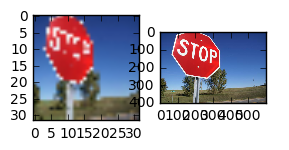

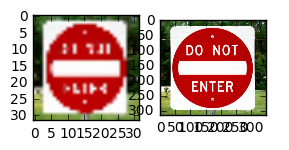

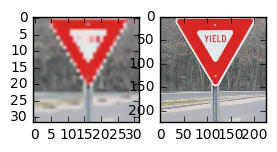

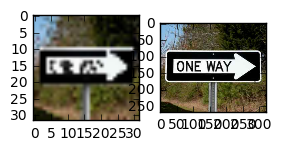

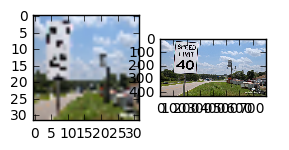

In [33]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
%matplotlib inline
def figplot(name):
    image_ = cv2.imread(name)
    image = cv2.resize(image_,(32,32))
    plt.figure(figsize=(3,3))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(image_, cv2.COLOR_BGR2RGB))
    return image

    
img1 = figplot("Image1_StopSign.jpg")
img2 = figplot("Image2_DoNotEnter.jpg")
img3 = figplot("Image3_DoNotEnter.jpg")
img4 = figplot("Image4_OneWay.jpg")
img5 = figplot("Image5_SpeedLimit.jpg")


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I chose 5 images of different american traffic signs offline. One of the first obvious challenges with these images is that they are not 32 by 32 pixels, and the images are not centered in the frame nor do they occupy the majority of the frame. Regardless, I am going to use the naive approach of coverting these to the correct size directoy with no further pre-processing. }

The naively scaled down image is on the left and the original is on the right.

Another obvious challenge is that I am using a network trained to classify german traffic signs to classify american traffic signs. This will  have mixed results.

In [39]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
images = preprocess([img1, img2, img3, img4, img5])
classifications = [14, 17, 13, 33, 1]
print("Correct Classifications are:")
print(classifications)
print()
classifications_one_hot = tf.one_hot(classifications, output_depth)

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('Traffic_Sign_Classifying_Net.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    my_logits = sess.run(logits, feed_dict={x: images, keep_prob_convlayers: 1., keep_prob_connected: 1.})
    predictions = tf.argmax(my_logits, 1)
    print("Predictions are:")
    print(predictions.eval())
    print()


    predict_correct = tf.equal(tf.argmax(my_logits, 1), tf.argmax(classifications_one_hot, 1))
    print("The following predictions are correct:")
    print(predict_correct.eval())
    print()
    my_accuracy = tf.reduce_mean(tf.cast(predict_correct, tf.float32))
    print("Which gives an accuracy of:")
    print(my_accuracy.eval())
    print()


Correct Classifications are:
[14, 17, 13, 33, 1]

Predictions are:
[20 17 13 34  1]

The following predictions are correct:
[False  True  True False  True]

Which gives an accuracy of:
0.6



### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

No, my model is not able to perform equally well. It had an accuracy of 60%. I imagine the reasons are similar to the challenges I listed in Question 6. These are american traffic signs, not german signs the network was trained on. The one-way sign (4th image) does not exist in the german set, so this one was obviously predicted incorrectly. However, the prediction was turn left ahead which is a reasonable prediction because it means it detected that it was an arrow. The speed limit sign, too, is different because while it has numbers, it is significantly different from the german signs

I also naively scalled full sized images down to the 32x32 size without cropping into a square first, or cropping around the actual sign. This distorted the images and 

In [53]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
print("Correct Classifications are:")
print(classifications)
print()
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('Traffic_Sign_Classifying_Net.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    probs = tf.nn.top_k(tf.nn.softmax(logits), k = 5)
    probabilities = sess.run(probs, feed_dict={x: images, keep_prob_convlayers: 1., keep_prob_connected: 1.})
    print(probabilities)

Correct Classifications are:
[14, 17, 13, 33, 1]

TopKV2(values=array([[  5.06562531e-01,   1.58400193e-01,   8.93689469e-02,
          4.82531600e-02,   3.23171206e-02],
       [  7.91175783e-01,   9.30441394e-02,   4.71178368e-02,
          3.87739390e-02,   5.54470252e-03],
       [  9.86915588e-01,   5.13651455e-03,   2.88560265e-03,
          2.23003351e-03,   4.97359550e-04],
       [  4.59732234e-01,   1.01718038e-01,   5.63225560e-02,
          3.09494156e-02,   3.00214235e-02],
       [  1.20476842e-01,   9.47792530e-02,   6.68851584e-02,
          6.26882538e-02,   5.72255999e-02]], dtype=float32), indices=array([[20, 28, 23, 38, 18],
       [17, 37, 14, 39, 34],
       [13, 11, 28, 20, 25],
       [34, 17,  9, 14, 13],
       [ 1, 34,  8,  2, 29]], dtype=int32))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**
The predictions the model is most certain of is with the "Do Not Enter" and "Yield" signs. It is not certain at all about the speed sign, which I believe is mostly due to the distortion from the naive conversion from a high fidelity to 32x32 image. It is also incorrectly 50% certain about the stop sign which is suprising

Where the model was incorrect about its initial prediction, the correct prediction does not appear in the top 5.

While I am not surprised that the speed sign and the one-way sign were hard for the classifier to get right, since these were either highly distorted or not in the german sign set at all, I am suprised how poorly it did with the stop sign. The american stop sign is fairly similar to the german stop sign so it should have been able to identify it correctly. I imagine it performed poorly on this one, again, because of the distortion from directly scaling down a high resolution image from the web.



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.